<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Bayesian Statistics With Baseball Data: Priors and Posteriors

_Authors: Kiefer Katovich (SF)_

---

Let’s review the general set up for Bayesian modeling. We have:

### $$P\left(\;model\;|\;data\;\right) = \frac{P\left(\;data\;|\;model\;\right)}{P(\;data\;)} P\left(\;model\;\right)$$

This is the diachronic interpretation of Bayes' theorem.

It can also be written as:

### $$posterior \propto likelihood \cdot prior$$

Here, the posterior is an update of our prior belief given the data observed.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import beta
from matplotlib import pyplot as plt

## Bayesian Analysis of Batting Averages

---

Load in the simple batting average data for players below. There are just four fields in the data set: the player's name, their times at bat, their hits, and their batting average.

> *Note: [This section of the lab is a partial replication of this exercise in R, if you're interested](https://www.r-bloggers.com/understanding-empirical-bayes-estimation-using-baseball-statistics/). Here, we took out the empirical Bayes section because it's not technically a correct interpretation of Bayesian statistical analysis.*

In [3]:
hits = pd.read_csv('data/career_hits.csv')

In [4]:
hits.head()

,name,hits,at_bat,average
0,Hank Aaron,3771,12364,0.304998
1,Tommie Aaron,216,944,0.228814
2,Andy Abad,2,21,0.095238
3,John Abadie,11,49,0.224490
4,Ed Abbaticchio,772,3044,0.253614


### 1) Find the top and bottom three hitters according to their average.

What is wrong with using the average to find the three best and worst hitters?

In [12]:
hits.sort_values('average', ascending=True).head(3).name

1494    Larry Ciaffone
7303        Jay Rogers
2552       Ferd Eunick
Name: name, dtype: object

In [10]:
hits.sort_values('average', ascending=False).head(3).name

5853     John Mohardt
9303        Al Wright
359     Jeff Banister
Name: name, dtype: object

Using these figures does not take into the account the number of times they are at bat.

### 2) Set up a prior distribution to represent our belief about batting average.

[After doing a quick search online](https://www.google.com/search?q=average+batting+average+for+players+mlb&oq=average+batting+average+for+players+mlb&aqs=chrome..69i57j0.7373j0j4&sourceid=chrome&ie=UTF-8), it looks like the overall batting average for MLB baseball players is around 0.260.

**Let's make it simple and say that our prior belief is that, out of 100 at-bats, we’ve seen 26 hits. Set up a beta distribution with `alpha=27` and `beta=75`. Plot it with the function from above.**

This is our distribution of beliefs on the batting average (probability of hitting while at bat) for MLB players.

In [16]:
beta(a=27,b=75).mean()

0.2647058823529412

In [18]:
alpha_prior = 27
beta_prior = 75

prior = beta(alpha_prior, beta_prior)

In [19]:
p = np.linspace(0.01,.99,100)

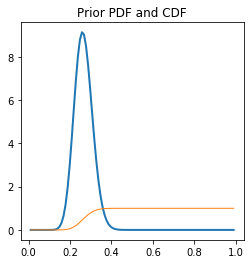

In [25]:
plt.figure(figsize=(4,4))
plt.plot(p,prior.pdf(p), lw=2);
plt.plot(p,prior.cdf(p), lw=1);
plt.title("Prior PDF and CDF");

### 3) Calculate the maximum a posteriori (MAP) estimate of players' batting averages.

The maximum a posteriori (MAP) estimate is the mode of a posterior distribution for a statistical parameter.

In our case, the MAP estimate for our players' batting averages will be the mode of the posterior beta distribution we get from updating our prior distribution with their at bats and hits.

---

> *Note: For an additional overview of the math behind updating the beta distribution posterior and conjugate priors, ([check out this website](https://alexanderetz.com/2015/07/25/understanding-bayes-updating-priors-via-the-likelihood/)).*

We need to update our beta distribution’s prior belief about batting averages with a player's at-bat and hit information to get a _new_ beta posterior distribution for that player's batting average. 

Luckily, with the beta distribution, the update is just a matter of adding in our new observations to the alpha and beta parameters, where alpha is the number of hits and beta is the number of misses/strikes:

    observed_hits = n_hits
    observed_misses = n_misses
    beta_prior = Beta(prior_hits+1, prior_misses+1)
    beta_posterior = Beta(prior_hits + n_nits + 1, prior_misses + n_misses + 1)
    
> **Note:** This process will also be useful in the context of A/B testing, which we’ll look at later on.

For each player, update the prior to the posterior distribution and calculate the mode of the distribution. The mode of a beta distribution is conveniently defined as:

### $$ \frac{\alpha - 1}{\alpha + \beta -2} $$

Which means we don't even need to use SciPy's beta distribution function. Just calculate the new alpha (hits) and beta (misses) for each player's posterior beta distribution and plug them into the formula above to get the MAP estimate of batting the average.

In [26]:
hits.head()

,name,hits,at_bat,average
0,Hank Aaron,3771,12364,0.304998
1,Tommie Aaron,216,944,0.228814
2,Andy Abad,2,21,0.095238
3,John Abadie,11,49,0.224490
4,Ed Abbaticchio,772,3044,0.253614


In [27]:
def map_func(row):
    alpha_posterior = alpha_prior + row['hits']
    beta_posterior  = beta_prior + (row['at_bat'] - row['hits'])
    return (alpha_posterior - 1) / (alpha_posterior + beta_posterior - 2)

In [28]:
hits['MAP'] = hits.apply(map_func, axis=1)

In [29]:
hits.head()

,name,hits,at_bat,average,MAP
0,Hank Aaron,3771,12364,0.304998,0.304637
1,Tommie Aaron,216,944,0.228814,0.231801
2,Andy Abad,2,21,0.095238,0.231405
3,John Abadie,11,49,0.224490,0.248322
4,Ed Abbaticchio,772,3044,0.253614,0.253817


### 4) Look up the top and bottom batters according to the MAP estimate.

In [35]:
hits.sort_values(by='MAP', ascending=True).head(3)

,name,hits,at_bat,average,MAP
4031,John Humphries,52,364,0.142857,0.168103
4322,Mike Jordan,12,125,0.096000,0.168889
2987,Ed Gastfield,6,88,0.068182,0.170213


In [36]:
hits.sort_values(by='MAP', ascending=False).head(3)

,name,hits,at_bat,average,MAP
3938,Rogers Hornsby,2930,8173,0.358497,0.357307
4118,Shoeless Joe Jackson,1772,4981,0.355752,0.353867
2109,Ed Delahanty,2596,7505,0.345903,0.344773


### 5) Plot the MLE batting average against the MAP batting average.

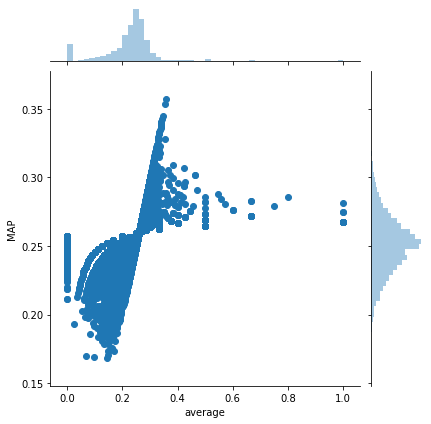

In [39]:
sns.jointplot(x='average', y='MAP',data=hits)